In [1]:
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
from tensorflow.keras.layers import TextVectorization

import cv2
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt


import sys
import os



In [67]:
ImgLocation="101_ObjectCategories/" # used Caltech 101 dataset

CATEGORIES = set(["cup"])

ImagePaths=[]
for category in CATEGORIES:
    for image in list(os.listdir(ImgLocation+category)):
        ImagePaths=ImagePaths+[ImgLocation+category+"/"+image]
        
# Load images and resize to 64 x 64
data_lowres=[]
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lowres = cv2.resize(image, (64, 64))
    data_lowres.append(image_lowres)
    
data_lowres = np.array(data_lowres, dtype="float") / 255.0

print("Shape of data_lowres: ", data_lowres.shape)

Shape of data_lowres:  (57, 64, 64, 3)


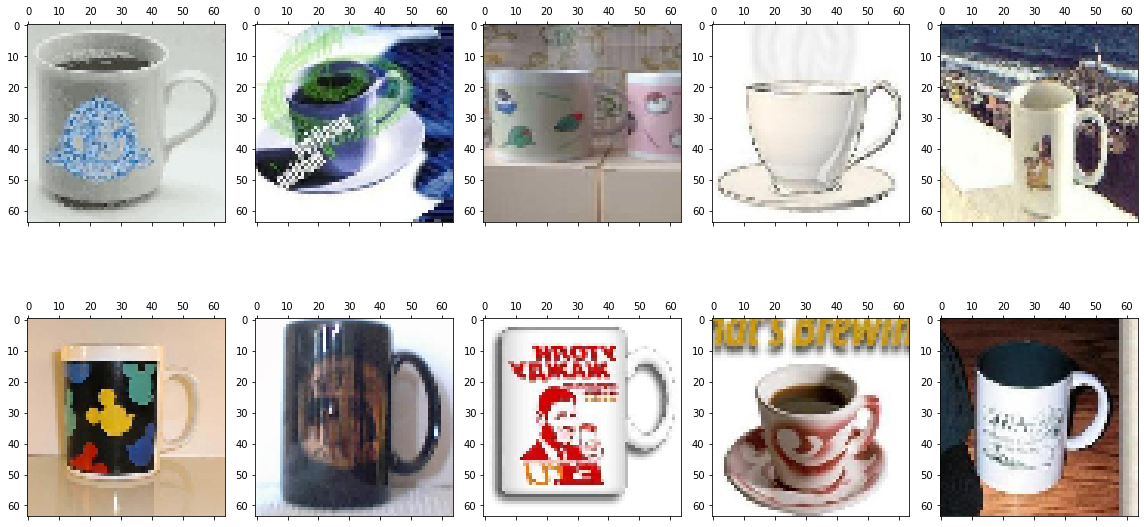

In [68]:
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(data_lowres[n])
        n=n+1
plt.show() 

In [69]:
scaler=MinMaxScaler(feature_range=(-1, 1))

data=data_lowres.copy()
print("Original shape of the data: ", data.shape)

data=data.reshape(-1, 1)
print("Reshaped data: ", data.shape)
scaler.fit(data)
data=scaler.transform(data)

data=data.reshape(data_lowres.shape[0], 64, 64, 3)
print("Shape of the scaled array: ", data.shape)

Original shape of the data:  (57, 64, 64, 3)
Reshaped data:  (700416, 1)
Shape of the scaled array:  (57, 64, 64, 3)


In [70]:
optim = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [79]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Conv2D(filters=64, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=(64,64,3)))
    model.add(layers.LeakyReLU(alpha=0.2))
        
    model.add(layers.Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=(64,64,3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=(64,64,3)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten(name='Discriminator-Flatten-Layer'))
    model.add(layers.Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) 
        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model

In [72]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(8*8*128, input_dim=latent_dim))
    model.add(layers.Reshape((8, 8, 128), name='Generator-Hidden-Layer-Reshape-1'))
    
    model.add(layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same'))
    model.add(layers.ReLU(name='Generator-Hidden-Layer-Activation-2'))
                              
    model.add(layers.Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same'))
    model.add(layers.ReLU(name='Generator-Hidden-Layer-Activation-3'))
    
    model.add(layers.Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same'))
    model.add(layers.ReLU(name='Generator-Hidden-Layer-Activation-4'))
    
    model.add(layers.Conv2D(filters=3, kernel_size=(5,5), activation='tanh', padding='same'))
    #model.compile(loss='binary_crossentropy', optimizer=optim)
    return model  

In [80]:
discriminator = build_discriminator()
generator = build_generator()

# Combined network
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

In [74]:
gan.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_21 (Sequential)  (None, 64, 64, 3)         3750275   
                                                                 
 sequential_20 (Sequential)  (None, 1)                 404801    
                                                                 
Total params: 4,155,076
Trainable params: 3,750,275
Non-trainable params: 404,801
_________________________________________________________________


In [75]:
def real_samples(n, ds):
    
    X = ds[np.random.choice(ds.shape[0], n, replace=True), :]
    y = np.ones((n, 1))
    
    return X, y
    
    
def latent_vector(latent_dim, n):
    
    latent_input = np.random.randn(latent_dim * n)
    latent_input = latent_input.reshape(n, latent_dim)
    
    return latent_input
  
    
def fake_samples(generator, latent_dim, n):
    
    latent_output = latent_vector(latent_dim, n)
    
    X = generator.predict(latent_output)
    y = np.zeros((n, 1))
    return X, y    

In [76]:
def performance_summary(generator, discriminator, dataset, latent_dim, n=50):
    
    x_real, y_real = real_samples(n, dataset)
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)
    
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 3)
    
    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,3):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show() 
    

In [77]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128, n_eval=20):
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        x_real, y_real = real_samples(half_batch, dataset)
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)
    
        x_gan = latent_vector(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)
        
        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim)

2/2 [==============================] - 13s 6s/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.687411904335022
Generator Loss:  0.6926268339157104


2/2 [==============================] - 9s 3s/step


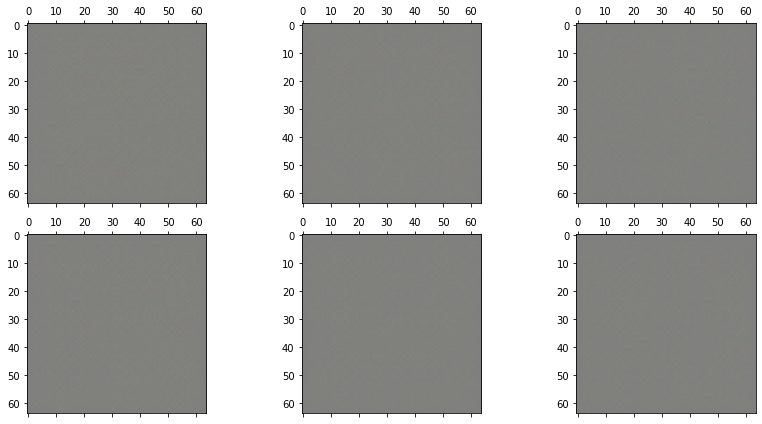

2/2 [==============================] - 11s 6s/step
Epoch number:  20
*** Training ***
Discriminator Loss  0.3591012954711914
Generator Loss:  0.8145368099212646
2/2 [==============================] - 9s 3s/step


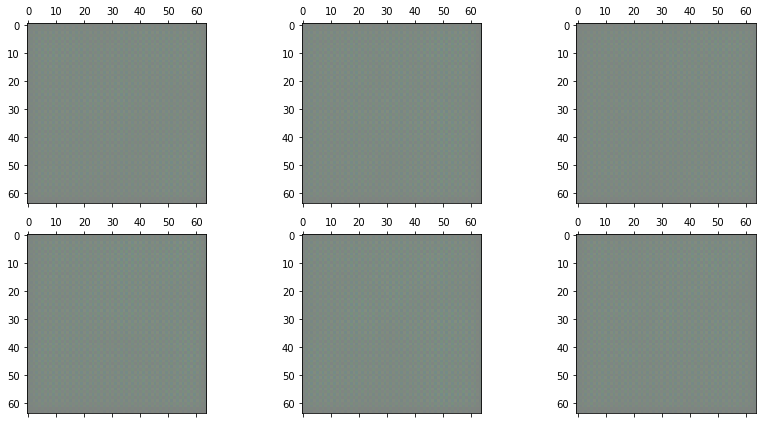

2/2 [==============================] - 11s 6s/step
Epoch number:  40
*** Training ***
Discriminator Loss  0.30626237392425537
Generator Loss:  2.811143398284912
2/2 [==============================] - 9s 3s/step


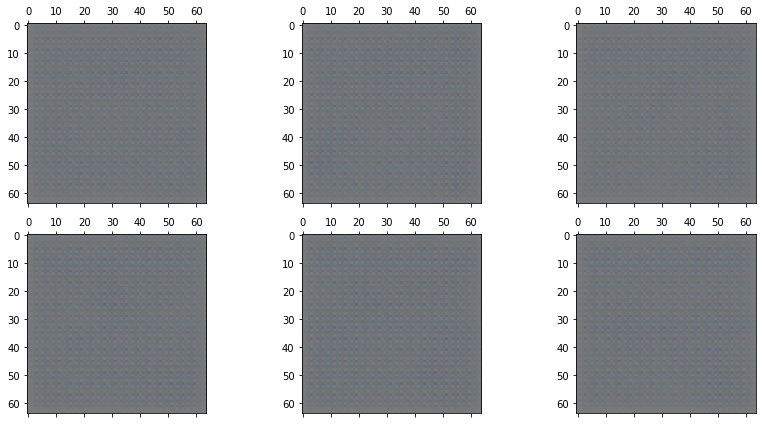

2/2 [==============================] - 13s 6s/step
Epoch number:  60
*** Training ***
Discriminator Loss  0.9227206707000732
Generator Loss:  1.5925620794296265
2/2 [==============================] - 9s 3s/step


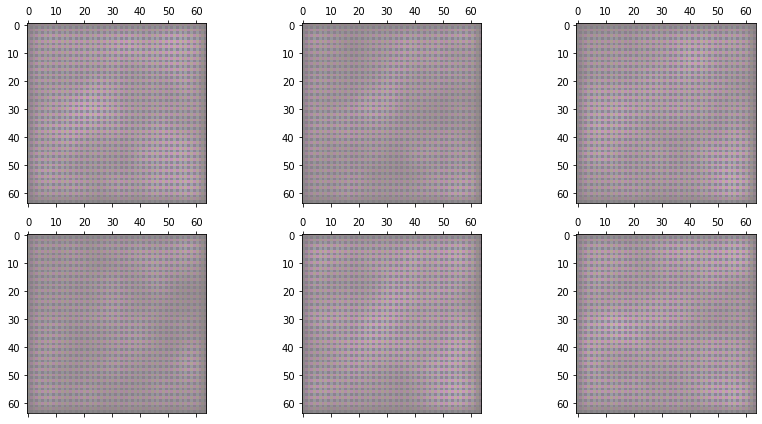

2/2 [==============================] - 11s 6s/step
Epoch number:  80
*** Training ***
Discriminator Loss  0.10394926369190216
Generator Loss:  2.1396617889404297
2/2 [==============================] - 9s 3s/step


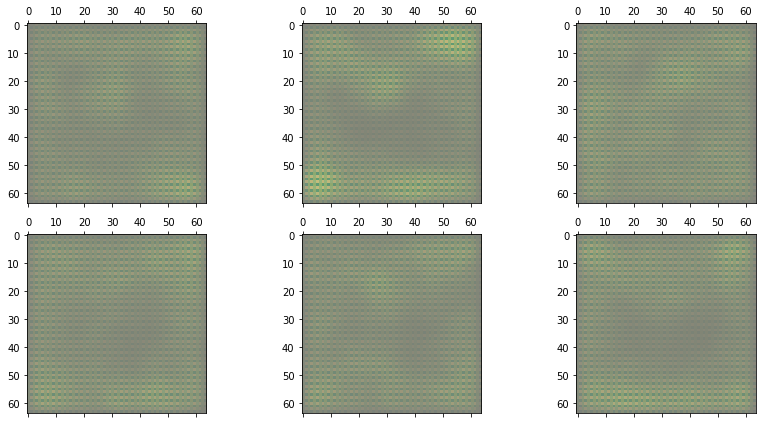

2/2 [==============================] - 12s 6s/step


In [81]:
train(generator, discriminator, gan, data, latent_dim)

Unfortunately, google colab started to warn me about resource usage and so on, so i decided to stop on 100 epoch...

# Translation

In [85]:
!wget https://ab6b-185-244-159-55.eu.ngrok.io/ukr-eng.zip # my local dataset downloaded from https://www.manythings.org/anki/ukr-eng.zip
!7z x ukr-eng.zip
text_file = "ukr.txt"

--2023-01-18 20:26:10--  https://ab6b-185-244-159-55.eu.ngrok.io/ukr-eng.zip
Resolving ab6b-185-244-159-55.eu.ngrok.io (ab6b-185-244-159-55.eu.ngrok.io)... 3.125.223.134, 2a05:d014:21b:8e00::6e:3
Connecting to ab6b-185-244-159-55.eu.ngrok.io (ab6b-185-244-159-55.eu.ngrok.io)|3.125.223.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4789080 (4.6M) [application/zip]
Saving to: ‘ukr-eng.zip’

ukr-eng.zip         100%[===================>]   4.57M  4.00MB/s    in 1.1s    

2023-01-18 20:26:12 (4.00 MB/s) - ‘ukr-eng.zip’ saved [4789080/4789080]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 4789080 bytes (4677 KiB)

Extracting archive: ukr-eng.zip
--
Path = ukr-eng.zip
Type = zip
Physical Size = 4789080

  0%    Everything is Ok

In [89]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, ukr, _ = line.split("\t")
    ukr = "[start] " + ukr + " [end]"
    text_pairs.append((eng, ukr))

In [91]:
for _ in range(5):
    import random
    print(random.choice(text_pairs))

('Tom still despises me.', '[start] Том все ще презирає мене. [end]')
("I know I shouldn't have eavesdropped.", '[start] Я знаю, що мені не слід було підслуховувати. [end]')
('What can we do about this?', '[start] Що ми можемо з цим зробити? [end]')
('I like your cat.', '[start] Мені подобається ваша кішка. [end]')
('He decided to sell the car.', '[start] Він вирішив продати свою машину. [end]')


In [92]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

156173 total pairs
109323 training pairs
23425 validation pairs
23425 test pairs


In [97]:
import string
import re

strip_chars = string.punctuation 
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
ukr_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_ukr_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
ukr_vectorization.adapt(train_ukr_texts)

In [99]:

def format_dataset(eng, ukr):
    eng = eng_vectorization(eng)
    ukr = ukr_vectorization(ukr)
    return ({"encoder_inputs": eng, "decoder_inputs": ukr[:, :-1],}, ukr[:, 1:])


def make_dataset(pairs):
    eng_texts, ukr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ukr_texts = list(ukr_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, ukr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [100]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [101]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config


In [104]:
embed_dim = 256
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [105]:
epochs = 1  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_2 (Positi  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_1 (Transfo  (None, None, 256)   2630144     ['positional_embedding_

In [106]:
ukr_vocab = ukr_vectorization.get_vocabulary()
ukr_index_lookup = dict(zip(range(len(ukr_vocab)), ukr_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ukr_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ukr_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

# HF Transformers: Pipeline

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 18.7 MB/s eta 0:00:00


In [6]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [7]:
classifier("i want to play football")

[{'label': 'POSITIVE', 'score': 0.966354250907898}]

In [8]:
classifier("i want to play football, but i hate football")

[{'label': 'NEGATIVE', 'score': 0.9912703037261963}]

In [9]:
classifier("i want to play football, but my leg is broken")

[{'label': 'NEGATIVE', 'score': 0.9979372024536133}]

In [10]:
classifier("i want to play football, because i love football")

[{'label': 'POSITIVE', 'score': 0.9970638155937195}]

In [12]:
classifier("i want to play football, because i love football. but someone will hurt me if i will do this")

[{'label': 'NEGATIVE', 'score': 0.999190628528595}]

In [14]:
classifier("i want to play football, because i love football. but someone will hurt me if i will do this. but i dont care")

[{'label': 'NEGATIVE', 'score': 0.9987768530845642}]

In [16]:
classifier("i want to play football, because i love football. but someone will hurt me if i will do this. but i dont care, i love pain")

[{'label': 'NEGATIVE', 'score': 0.9924138188362122}]

In [18]:
classifier("i love pain")

[{'label': 'POSITIVE', 'score': 0.9176785349845886}]

In [19]:
classifier("bad things happens to me")

[{'label': 'NEGATIVE', 'score': 0.9997604489326477}]

In [23]:
classifier("bad things happens to me, but i love it, however my mother hate it")

[{'label': 'POSITIVE', 'score': 0.9977598190307617}]